In [1]:
import xarray as xr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import cartopy.crs as ccrs

from deepmip_dict import deepmip_dict

data_dir = '/Users/wb19586/Documents/coding_github/aprp_deepmip/aprp_output_data/'
cmip_dir = '/Users/wb19586/Documents/coding_github/aprp_deepmip/data/cmip6/'
deepmip_dir = '/Users/wb19586/Documents/data/deepmip_database/deepmip-eocene-p1/'


In [2]:
#### state dependence of global mean feedbacks

def select_area(da,min_lat,max_lat, lat_name='lat'):
    # Check if the latitude dimension is monotonically increasing or decreasing
    if da[lat_name].values[0] < da[lat_name].values[-1]:
        # Latitude is increasing
        return da.sel(lat=slice(min_lat, max_lat))
    else:
        # Latitude is decreasing
        return da.sel(lat=slice(max_lat, min_lat))

# calculate global mean feedback strengths first

# DeepMIP
gmsts = {}
feedbacks_gm = {}
feedbacks_NP = {}
feedbacks_SP = {}
feedbacks_T = {}

for model in deepmip_dict.keys():
    for i in range(deepmip_dict[model]['ncase']-1):

        if deepmip_dict[model]['contr'][i] == 'deepmip-eocene-p1-PI':
            continue
            
        aprp_file = model + '.' + deepmip_dict[model]['contr'][i] +'.to.' + deepmip_dict[model]['sensi'][i] + '.aprp.nc'
        aprp      = xr.open_dataset(data_dir + '/deepmip/' + aprp_file, decode_times=False)
        aprp = aprp.where(aprp <= 1e6, np.nan)
        aprp_ym   = aprp.mean('time')

        # calculate area weights
        coslat     = np.cos(np.deg2rad(aprp.lat))
        
        gmst1     = aprp_ym['tas1'].weighted(coslat).mean(('lat','lon')) - 273.15
        gmst2     = aprp_ym['tas2'].weighted(coslat).mean(('lat','lon')) - 273.15
        dT        = (gmst2 - gmst1).values

        gmsts[f"{model}_{deepmip_dict[model]['contr'][i]}"] = gmst1

        var_list = ['alf','alf_clr','alf_oc','cld','cld_c','cld_ga','cld_mu','clr','clr_ga','clr_mu']
        for var in var_list:
            aprp_ym_NP = select_area(aprp_ym[var],60,90)
            aprp_ym_SP = select_area(aprp_ym[var],-90,-60)
            aprp_ym_T = select_area(aprp_ym[var],-30,30)

            coslat_NP = np.cos(np.deg2rad(aprp_ym_NP.lat))
            coslat_SP = np.cos(np.deg2rad(aprp_ym_SP.lat))
            coslat_T = np.cos(np.deg2rad(aprp_ym_T.lat))

            feedback_gm = aprp_ym[var].weighted(coslat).mean(('lat','lon')) / dT
            feedback_NP = aprp_ym_NP.weighted(coslat_NP).mean(('lat','lon')) / dT
            feedback_SP = aprp_ym_SP.weighted(coslat_SP).mean(('lat','lon')) / dT
            feedback_T = aprp_ym_T.weighted(coslat_T).mean(('lat','lon')) / dT

            feedbacks_gm[f"{model}_{var}_{deepmip_dict[model]['contr'][i]}"] = feedback_gm
            feedbacks_NP[f"{model}_{var}_{deepmip_dict[model]['contr'][i]}"] = feedback_NP
            feedbacks_SP[f"{model}_{var}_{deepmip_dict[model]['contr'][i]}"] = feedback_SP
            feedbacks_T[f"{model}_{var}_{deepmip_dict[model]['contr'][i]}"] = feedback_T

# CMIP
gmsts_cmip = []
feedbacks_gm_cmip = {}
feedbacks_NP_cmip = {}
feedbacks_SP_cmip = {}
feedbacks_T_cmip = {}

for model in os.listdir(cmip_dir + "piControl/"):

    if model == '.DS_Store' or model == 'IPSL-CM6A-LR' or model == 'CMCC-CM2-SR5' or model == 'FGOALS-g3':
        continue
    
    aprp_file = model + '.piControl.to.abrupt-4xCO2.aprp.nc'
    aprp      = xr.open_dataset(data_dir + '/cmip/' + aprp_file, decode_times=False)
    aprp = aprp.where(aprp <= 1e6, np.nan)
    aprp_ym   = aprp.mean('time')

    # calculate area weights
    coslat     = np.cos(np.deg2rad(aprp.lat))
    
    gmst1     = aprp_ym['tas1'].weighted(coslat).mean(('lat','lon')) - 273.15
    gmst2     = aprp_ym['tas2'].weighted(coslat).mean(('lat','lon')) - 273.15
    dT        = (gmst2 - gmst1).values

    gmsts_cmip.append(gmst1.values)

    var_list = ['alf','alf_clr','alf_oc','cld','cld_c','cld_ga','cld_mu','clr','clr_ga','clr_mu']
    for var in var_list:
        aprp_ym_NP = select_area(aprp_ym[var],60,90)
        aprp_ym_SP = select_area(aprp_ym[var],-90,-60)
        aprp_ym_T = select_area(aprp_ym[var],-30,30)

        coslat_NP = np.cos(np.deg2rad(aprp_ym_NP.lat))
        coslat_SP = np.cos(np.deg2rad(aprp_ym_SP.lat))
        coslat_T = np.cos(np.deg2rad(aprp_ym_T.lat))

        feedback_gm = aprp_ym[var].weighted(coslat).mean(('lat','lon')) / dT
        feedback_NP = aprp_ym_NP.weighted(coslat_NP).mean(('lat','lon')) / dT
        feedback_SP = aprp_ym_SP.weighted(coslat_SP).mean(('lat','lon')) / dT
        feedback_T = aprp_ym_T.weighted(coslat_T).mean(('lat','lon')) / dT

        feedbacks_gm_cmip[f"{var}_cmip_{model}"] = feedback_gm
        feedbacks_NP_cmip[f"{var}_cmip_{model}"] = feedback_NP
        feedbacks_SP_cmip[f"{var}_cmip_{model}"] = feedback_SP
        feedbacks_T_cmip[f"{var}_cmip_{model}"] = feedback_T


In [3]:
# define the plotting function
# to do:
# change strength to parameter
def plot_feedbacks_area_means(feedbacks_dict, feedbacks_dict_cmip, axs, fig, ymin, ymax, title):
    row    = 0
    column = 0   
    for var in var_list:
        for model in deepmip_dict.keys():
            model_gmsts = []
            for key, data_array in gmsts.items():
                if key.startswith(model):
                    model_gmsts.append(data_array.item())
            model_feedbacks = []
            for key, data_array in feedbacks_dict.items():
                if key.startswith(f"{model}_{var}_deepmip"):
                    model_feedbacks.append(data_array.item())                
            cmip_feedbacks = []
            for key, data_array in feedbacks_dict_cmip.items():
                if key.startswith(f"{var}_cmip_"):
                    cmip_feedbacks.append(data_array.item())  

            axs[row,column].axhline(y=0.0, color='gray', linestyle='--',zorder=1)

            axs[row,column].boxplot(cmip_feedbacks, positions=[np.mean(gmsts_cmip)], widths=1.5)
            
            axs[row,column].plot(model_gmsts, model_feedbacks, marker="o", markersize=12, markeredgecolor='k', color=deepmip_dict[model]['pcolor'], label=deepmip_dict[model]['group'],zorder=100)
            axs[row,column].set_title(var, fontsize=16)
            axs[row,column].set_xlabel('GMST [°C]', fontsize=11)
            axs[row,column].set_ylabel('feedback strength [Wm$^{-2}$°C$^{-1}$]', fontsize=11)
            axs[row,column].set_ylim([ymin, ymax])
            axs[row,column].set_xlim([12.0, 32.5])
            axs[row,column].set_xticks([12.5,15,17.5,20,22.5,25,27.5,30,32.5], ["","15","","20","","25","","30",""])

        
        if var == 'alf_oc':
            row = 1
            column = 0
        elif var == 'cld_mu':
            row = 2
            column = 0   
        else:
            column += 1
    # Adjustments to the figure
    axs[2,2].legend(prop={"size": 9})
    axs[0, 3].axis('off')
    axs[2, 3].axis('off')
    fig.suptitle(title, fontsize=24)
    fig.tight_layout()



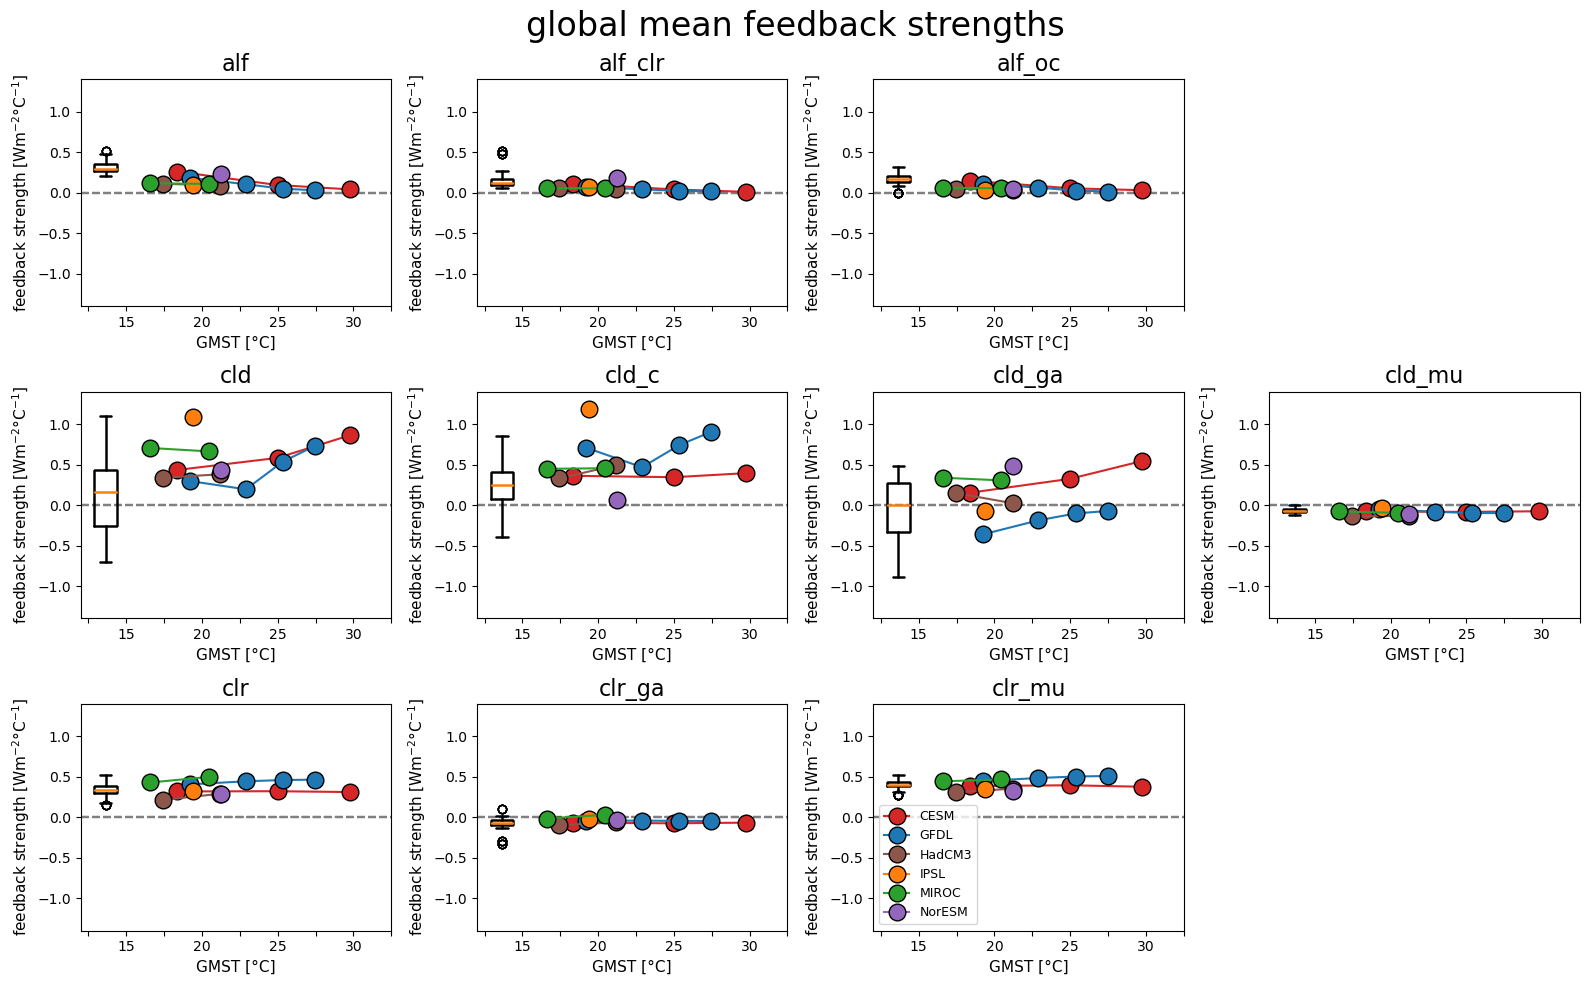

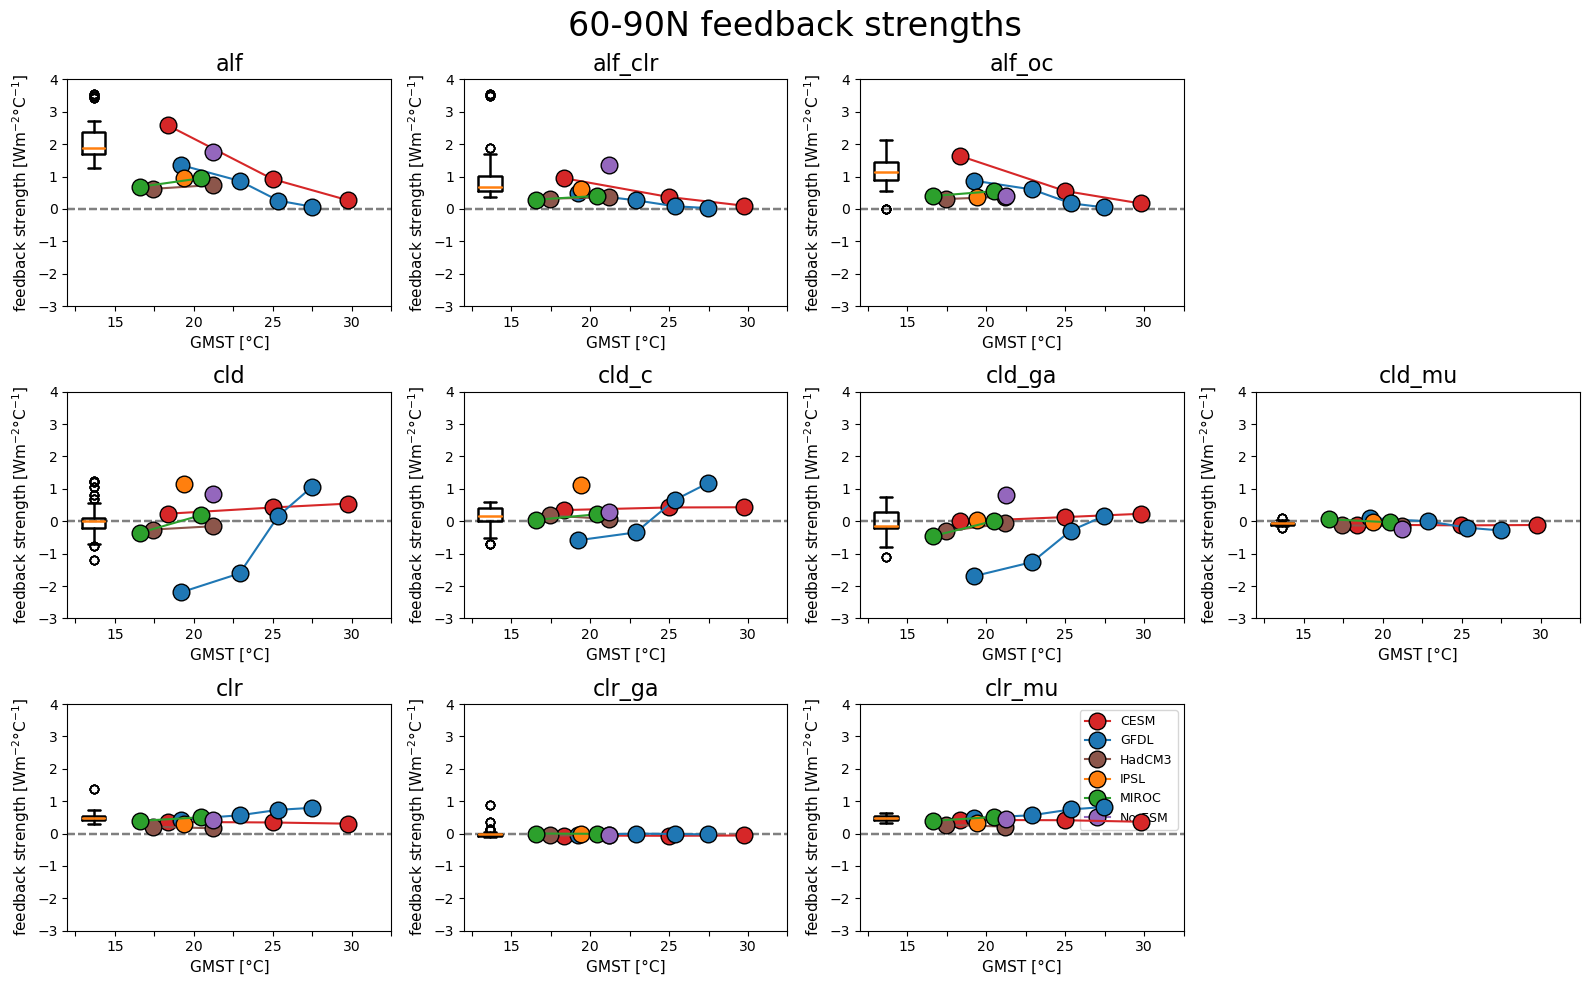

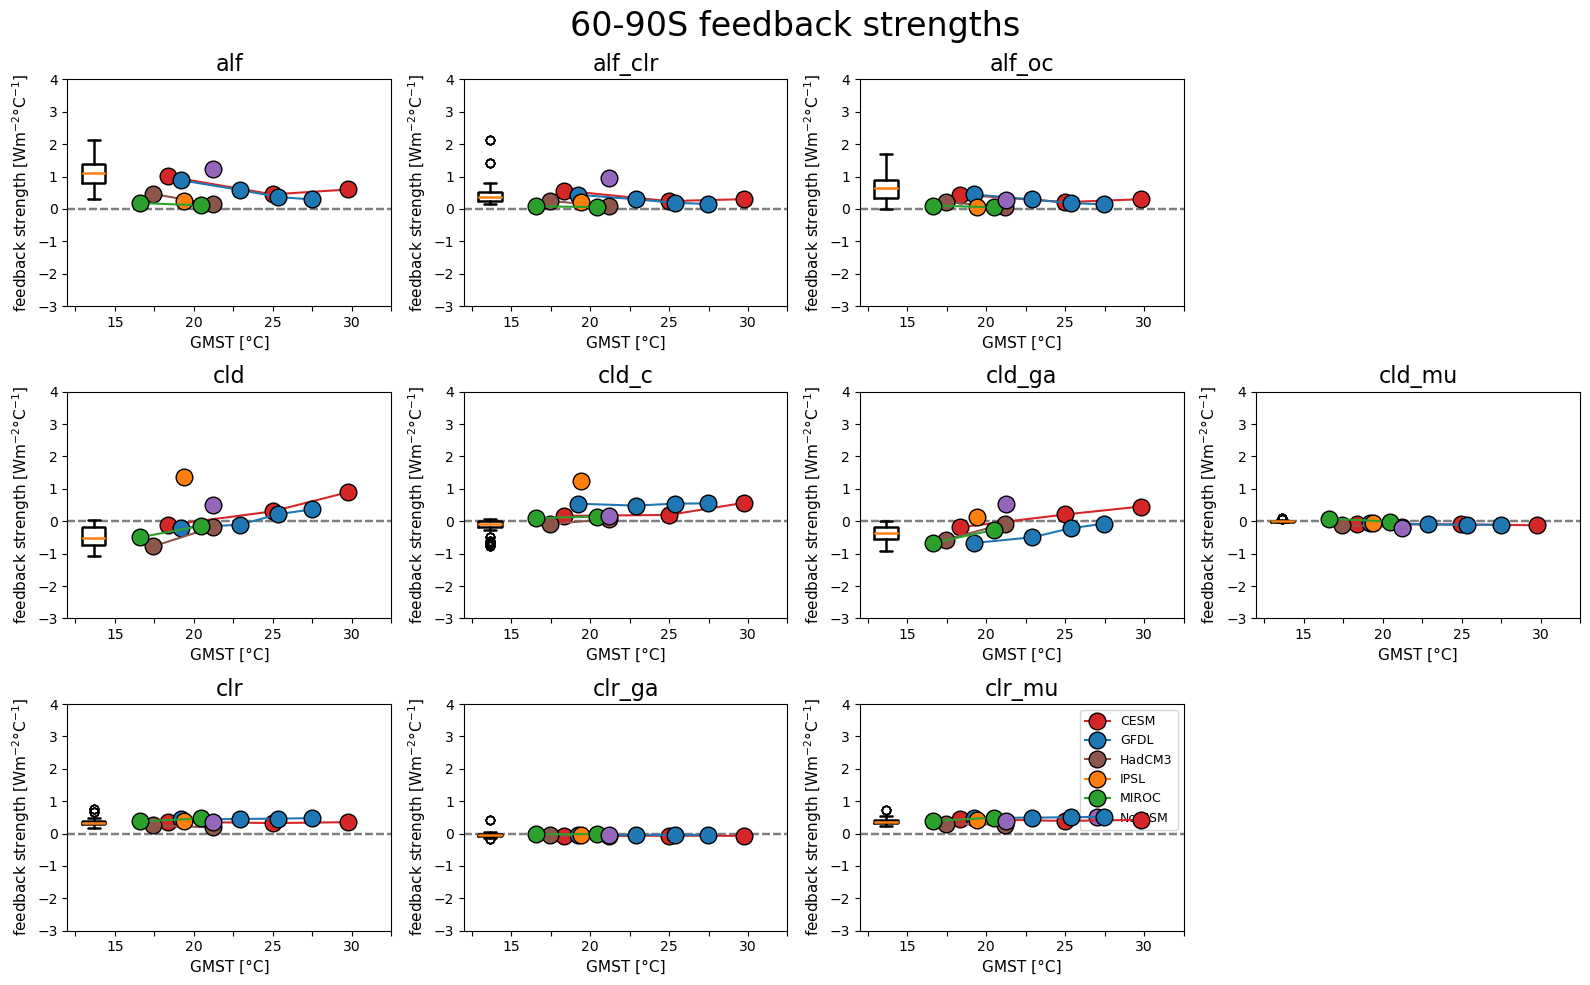

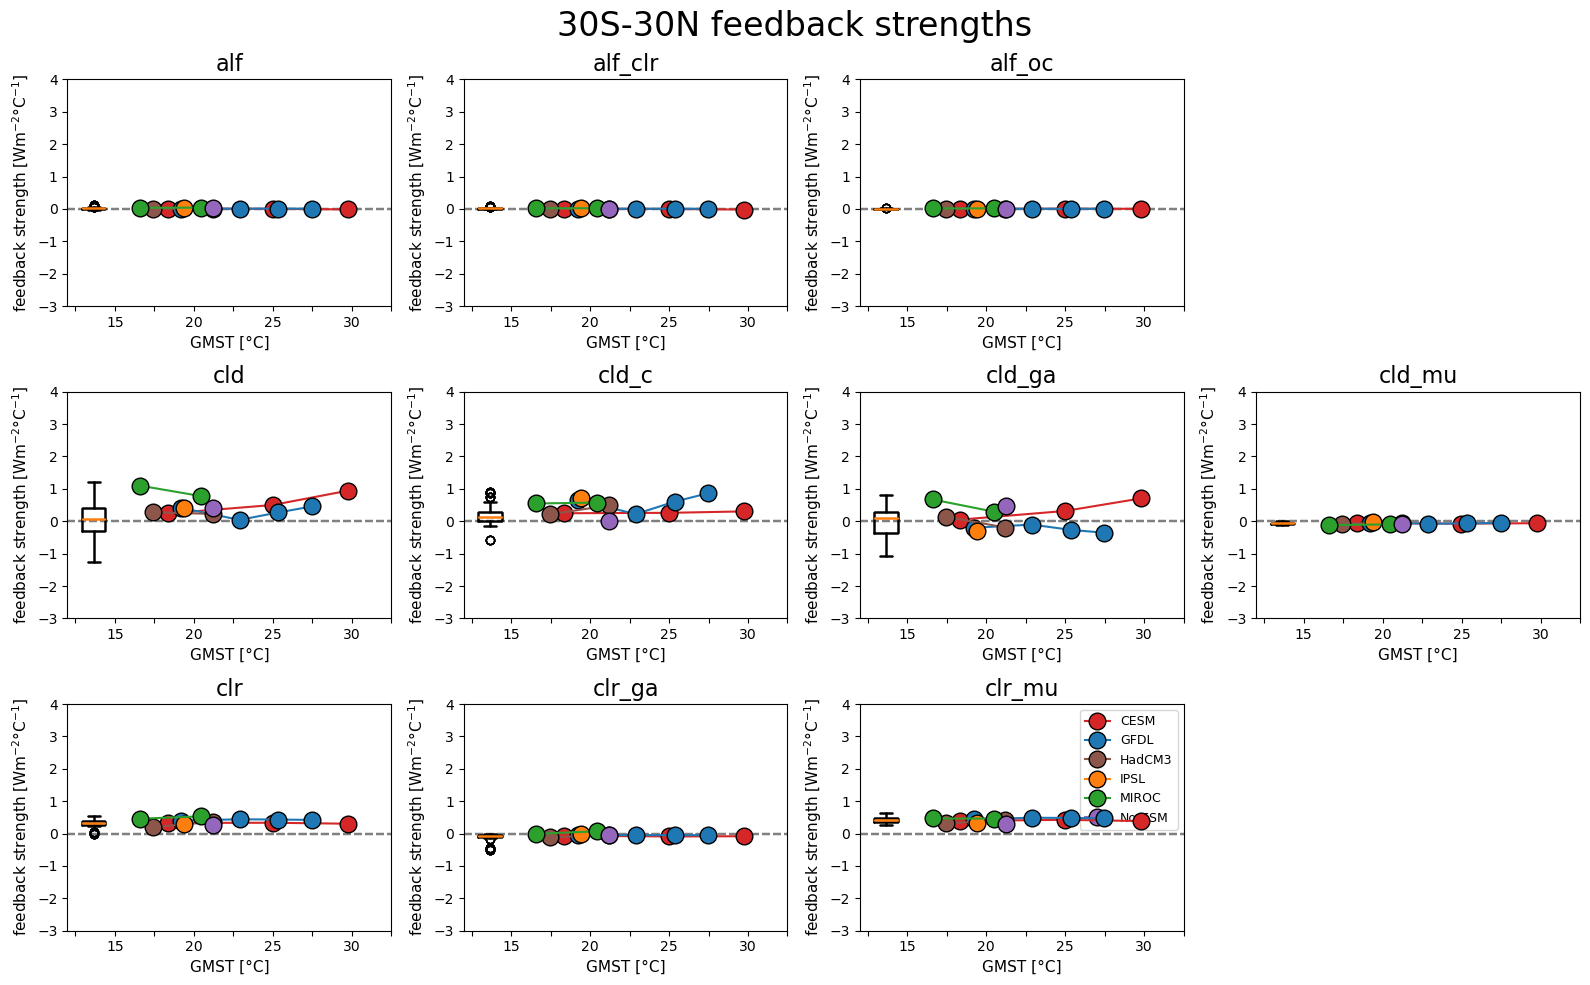

In [4]:
# Create the figures
fig, axs = plt.subplots(3, 4, figsize=(16, 10))
plot_feedbacks_area_means(feedbacks_gm, feedbacks_gm_cmip, axs, fig, -1.4, 1.4, "global mean feedback strengths")

fig, axs = plt.subplots(3, 4, figsize=(16, 10))
plot_feedbacks_area_means(feedbacks_NP, feedbacks_NP_cmip, axs, fig, -3.0, 4.0, "60-90N feedback strengths")

fig, axs = plt.subplots(3, 4, figsize=(16, 10))
plot_feedbacks_area_means(feedbacks_SP, feedbacks_SP_cmip, axs, fig, -3.0, 4.0, "60-90S feedback strengths")

fig, axs = plt.subplots(3, 4, figsize=(16, 10))
plot_feedbacks_area_means(feedbacks_T, feedbacks_T_cmip, axs, fig, -3.0, 4.0, "30S-30N feedback strengths")

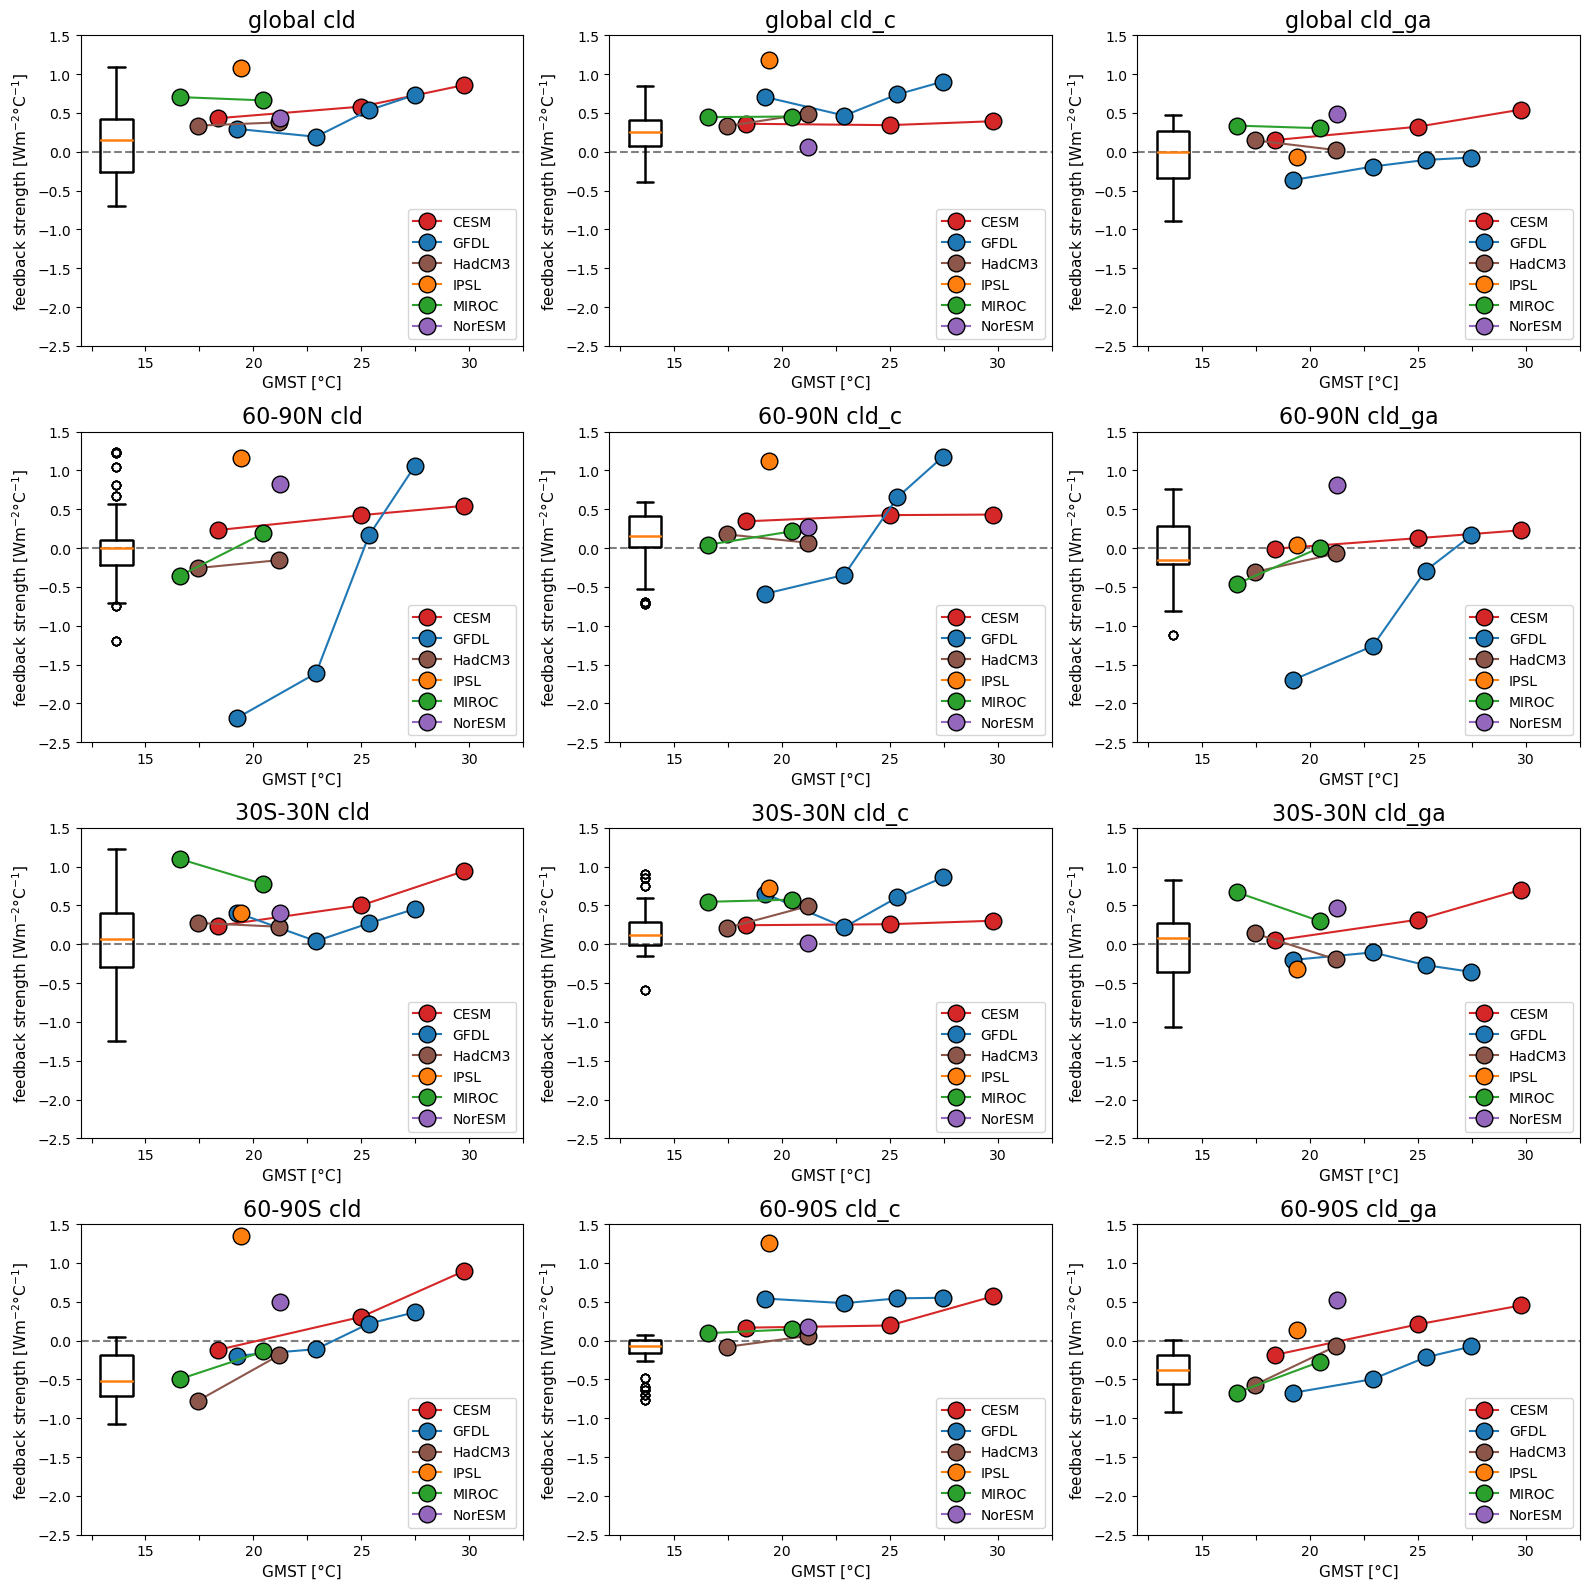

In [5]:
## focus on main cloud components

def retrieve_feedbacks(dict_deepmip, dict_cmip):
    model_feedbacks = []
    for key, data_array in dict_deepmip.items():
        if key.startswith(f"{model}_{var}_deepmip"):
            model_feedbacks.append(data_array.item())                
    cmip_feedbacks = []
    for key, data_array in dict_cmip.items():
        if key.startswith(f"{var}_cmip_"):
            cmip_feedbacks.append(data_array.item())  
    return model_feedbacks, cmip_feedbacks
        

fig, axs = plt.subplots(4, 3, figsize=(16, 16))

var_list = ['cld','cld_c','cld_ga']

for var_idx,var in enumerate(var_list):
    for model in deepmip_dict.keys():
        model_gmsts = []
        for key, data_array in gmsts.items():
            if key.startswith(model):
                model_gmsts.append(data_array.item())
        model_feedbacks_gm, cmip_feedbacks_gm = retrieve_feedbacks(feedbacks_gm, feedbacks_gm_cmip)
        model_feedbacks_NP, cmip_feedbacks_NP = retrieve_feedbacks(feedbacks_NP, feedbacks_NP_cmip)
        model_feedbacks_SP, cmip_feedbacks_SP = retrieve_feedbacks(feedbacks_SP, feedbacks_SP_cmip)
        model_feedbacks_T, cmip_feedbacks_T = retrieve_feedbacks(feedbacks_T, feedbacks_T_cmip)

        axs[0,var_idx].set_title('global ' + var, fontsize=16)
        axs[0,var_idx].boxplot(cmip_feedbacks_gm, positions=[np.mean(gmsts_cmip)], widths=1.5)
        axs[0,var_idx].plot(model_gmsts, model_feedbacks_gm, marker="o", markersize=12, markeredgecolor='k', color=deepmip_dict[model]['pcolor'], label=deepmip_dict[model]['group'],zorder=100)

        axs[1,var_idx].set_title('60-90N ' + var, fontsize=16)
        axs[1,var_idx].boxplot(cmip_feedbacks_NP, positions=[np.mean(gmsts_cmip)], widths=1.5)
        axs[1,var_idx].plot(model_gmsts, model_feedbacks_NP, marker="o", markersize=12, markeredgecolor='k', color=deepmip_dict[model]['pcolor'], label=deepmip_dict[model]['group'],zorder=100)

        axs[2,var_idx].set_title('30S-30N ' + var, fontsize=16)
        axs[2,var_idx].boxplot(cmip_feedbacks_T, positions=[np.mean(gmsts_cmip)], widths=1.5)
        axs[2,var_idx].plot(model_gmsts, model_feedbacks_T, marker="o", markersize=12, markeredgecolor='k', color=deepmip_dict[model]['pcolor'], label=deepmip_dict[model]['group'],zorder=100)

        axs[3,var_idx].set_title('60-90S ' + var, fontsize=16)
        axs[3,var_idx].boxplot(cmip_feedbacks_SP, positions=[np.mean(gmsts_cmip)], widths=1.5)
        axs[3,var_idx].plot(model_gmsts, model_feedbacks_SP, marker="o", markersize=12, markeredgecolor='k', color=deepmip_dict[model]['pcolor'], label=deepmip_dict[model]['group'],zorder=100)
     


# fig.suptitle(title, fontsize=24)

for ax in axs.flat:
    ax.set_xlabel('GMST [°C]', fontsize=11)
    ax.axhline(y=0.0, color='gray', linestyle='--',zorder=1)
    ax.set_ylabel('feedback strength [Wm$^{-2}$°C$^{-1}$]', fontsize=11)
    ax.set_ylim([-2.5, 1.5])
    ax.set_xlim([12.0, 32.5])
    ax.set_xticks([12.5,15,17.5,20,22.5,25,27.5,30,32.5], ["","15","","20","","25","","30",""])
    ax.legend(loc="lower right", prop={"size": 10})

fig.tight_layout()




- global mean cloud feedbacks in DeepMIP models always > 0 and at upper end of CMIP6 range
- tendency of increase with GMST
- strongest feedback in IPSL due to reduction in (mainly high-latitdue) clouds, which is much stronger than in CMIP6
- strongest nonlinearity in GFDL Arctic; extreme negative feedback switches sign at around 25 °C (both due to change in number of clouds and composition)
- overall nonlinear tendency seems to be related to scaterring/composition changes (not amount), particular over ice-free Antarctica!
- consistency in increaseing feddback strength over high latitudes, but inconsistencies in low latitudes, especially in scattering term

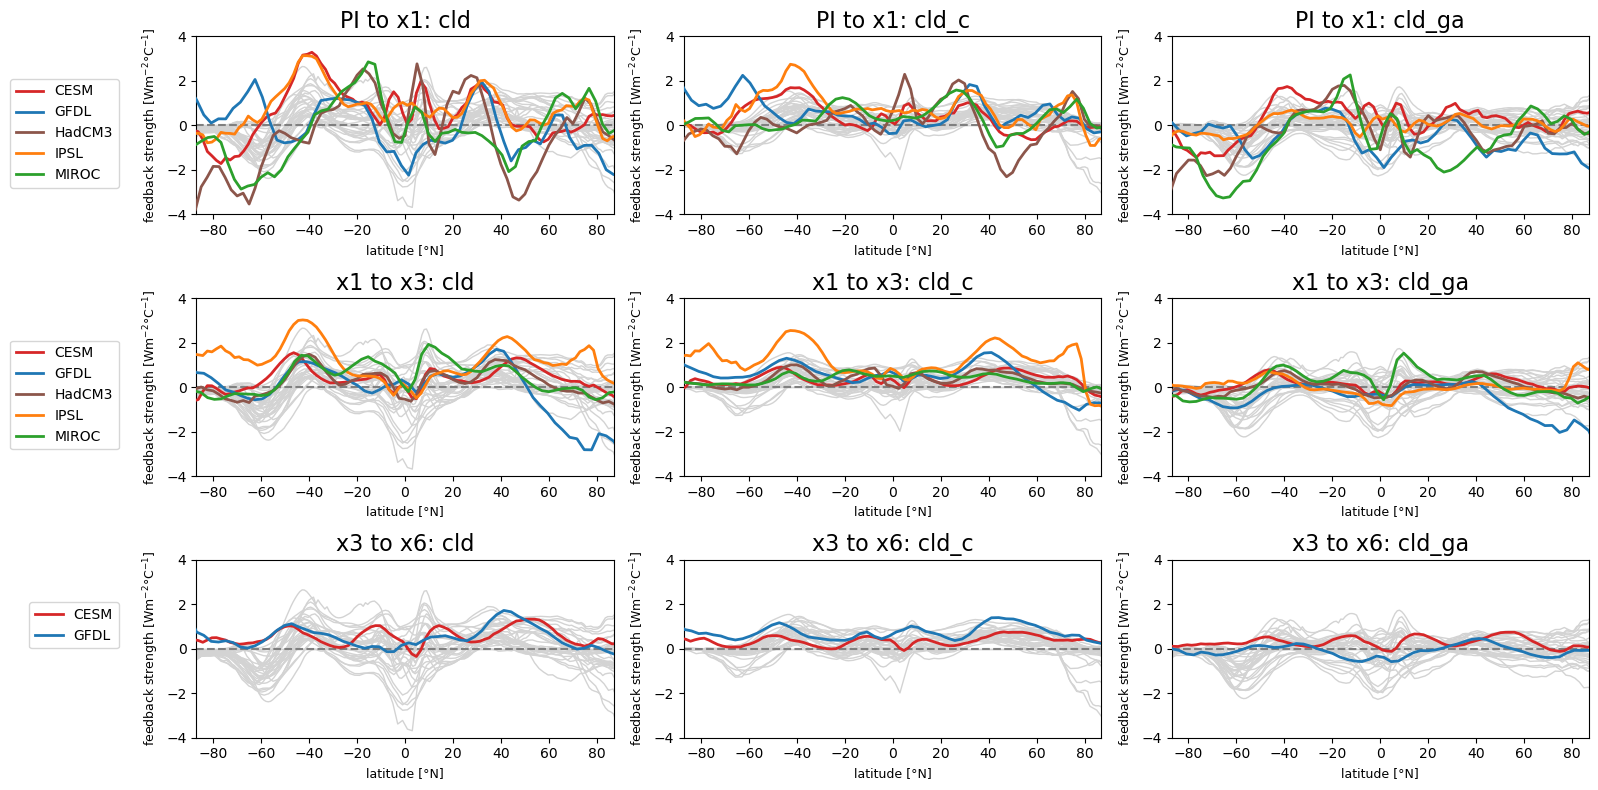

In [6]:
# zonal mean view
fig, axs = plt.subplots(3, 3, figsize=(16, 8))

# cmip6 background models
for model in os.listdir(cmip_dir + "piControl/"):

    if model == '.DS_Store' or model == 'IPSL-CM6A-LR' or model == 'CMCC-CM2-SR5':
        continue
    
    aprp_file = model + '.piControl.to.abrupt-4xCO2.aprp.nc'
    aprp      = xr.open_dataset(data_dir + '/cmip/' + aprp_file, decode_times=False)
    aprp = aprp.where(aprp <= 1e6, np.nan)
    aprp_ym   = aprp.mean('time')

    # calculate area weights
    coslat     = np.cos(np.deg2rad(aprp.lat))
    
    gmst1     = aprp_ym['tas1'].weighted(coslat).mean(('lat','lon')) - 273.15
    gmst2     = aprp_ym['tas2'].weighted(coslat).mean(('lat','lon')) - 273.15
    dT        = (gmst2 - gmst1).values

    var_list = ['cld','cld_c','cld_ga']
    for var_idx, var in enumerate(var_list):
        aprp_ym_zm = aprp_ym[var].mean('lon') / dT
        axs[0,var_idx].plot(aprp_ym.lat, aprp_ym_zm, linewidth=1, color='lightgray', zorder=1 )
        axs[1,var_idx].plot(aprp_ym.lat, aprp_ym_zm, linewidth=1, color='lightgray', zorder=1 )
        axs[2,var_idx].plot(aprp_ym.lat, aprp_ym_zm, linewidth=1, color='lightgray', zorder=1 )
        

for model in deepmip_dict.keys():

    if model == 'NorESM1-F':
        continue
    elif model == 'IPSLCM5A2':
        file_1 = model + '.deepmip-eocene-p1-PI.to.deepmip-eocene-p1-x1.5.aprp.nc'
        file_2 = model + '.deepmip-eocene-p1-x1.5.to.deepmip-eocene-p1-x3.aprp.nc'
    else:
        file_1 = model + '.deepmip-eocene-p1-PI.to.deepmip-eocene-p1-x1.aprp.nc'
        file_2 = model + '.deepmip-eocene-p1-x1.to.deepmip-eocene-p1-x3.aprp.nc'

    aprp_1      = xr.open_dataset(data_dir + '/deepmip/' + file_1, decode_times=False)
    aprp_1 = aprp_1.where(aprp_1 <= 1e6, np.nan)
    aprp_1_ym   = aprp_1.mean('time')

    aprp_2      = xr.open_dataset(data_dir + '/deepmip/' + file_2, decode_times=False)
    aprp_2 = aprp_2.where(aprp_2 <= 1e6, np.nan)
    aprp_2_ym   = aprp_2.mean('time')

    # calculate area weights
    coslat     = np.cos(np.deg2rad(aprp_1_ym.lat))
    
    gmst1     = aprp_1_ym['tas1'].weighted(coslat).mean(('lat','lon')) - 273.15
    gmst2     = aprp_1_ym['tas2'].weighted(coslat).mean(('lat','lon')) - 273.15
    dT1        = (gmst2 - gmst1).values

    gmst1     = aprp_2_ym['tas1'].weighted(coslat).mean(('lat','lon')) - 273.15
    gmst2     = aprp_2_ym['tas2'].weighted(coslat).mean(('lat','lon')) - 273.15
    dT2       = (gmst2 - gmst1).values

    if model == 'CESM1.2-CAM5' or model == 'GFDL-CM2.1':
        file_3 = model + '.deepmip-eocene-p1-x3.to.deepmip-eocene-p1-x6.aprp.nc'
        aprp_3      = xr.open_dataset(data_dir + '/deepmip/' + file_3, decode_times=False)
        aprp_3      = aprp_3.where(aprp_3 <= 1e6, np.nan)
        aprp_3_ym   = aprp_3.mean('time')

        gmst1     = aprp_3_ym['tas1'].weighted(coslat).mean(('lat','lon')) - 273.15
        gmst2     = aprp_3_ym['tas2'].weighted(coslat).mean(('lat','lon')) - 273.15
        dT3       = (gmst2 - gmst1).values
        
    var_list = ['cld','cld_c','cld_ga']
    for var_idx, var in enumerate(var_list):
        
        aprp_1_ym_zm = aprp_1_ym[var].mean('lon') / dT1
        axs[0,var_idx].set_title("PI to x1: " + var, fontsize=16)
        axs[0,var_idx].plot(aprp_1_ym.lat, aprp_1_ym_zm, linewidth=2, color=deepmip_dict[model]['pcolor'], label=deepmip_dict[model]['group'], zorder=999 )

        aprp_2_ym_zm = aprp_2_ym[var].mean('lon') / dT2
        axs[1,var_idx].set_title("x1 to x3: " + var, fontsize=16)
        axs[1,var_idx].plot(aprp_2_ym.lat, aprp_2_ym_zm, linewidth=2, color=deepmip_dict[model]['pcolor'], label=deepmip_dict[model]['group'], zorder=999 )

        if model == 'CESM1.2-CAM5' or model == 'GFDL-CM2.1':
            aprp_3_ym_zm = aprp_3_ym[var].mean('lon') / dT3
            axs[2,var_idx].set_title("x3 to x6: " + var, fontsize=16)
            axs[2,var_idx].plot(aprp_3_ym.lat, aprp_3_ym_zm, linewidth=2, color=deepmip_dict[model]['pcolor'], label=deepmip_dict[model]['group'], zorder=999 )
            
for ax in axs.flat:
    ax.set_xlabel('latitude [°N]', fontsize=9)
    ax.axhline(y=0.0, color='gray', linestyle='--',zorder=1)
    ax.set_ylabel('feedback strength [Wm$^{-2}$°C$^{-1}$]', fontsize=9)
    ax.set_ylim([-4, 4])
    ax.set_xlim([-87, 87])
    # ax.set_xticks([12.5,15,17.5,20,22.5,25,27.5,30,32.5], ["","15","","20","","25","","30",""])
    
axs[0,0].legend( prop={"size": 10}, bbox_to_anchor=(-0.17, 0.8))
axs[1,0].legend( prop={"size": 10}, bbox_to_anchor=(-0.17, 0.8))
axs[2,0].legend( prop={"size": 10}, bbox_to_anchor=(-0.17, 0.8))

fig.tight_layout()


- large spread in cloud response in DeepMIP ensemble
- x1 to x3 highlights again the overall positive DeepMIP cloud feedbacks
- strong warming in IPSL due to less clouds in high latitudes
- strong cooling in GFDL in NH high latitudes, mainly due to scattering (i.e. composition changes)
- x3-x6 GFDL model in Arctic now very similar to CESM and CMIP6 models

In [7]:
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_feedback_maps(var, model, vmin, vmax):
    fig, axs = plt.subplots(2, 2, figsize=(12, 6), subplot_kw={'projection': ccrs.Robinson()})

    colormap = plt.cm.RdBu_r
    min_value = vmin 
    max_value = vmax
    levels = np.linspace(min_value, max_value, 11)  # 11 edges for 10 intervals
    norm = mcolors.BoundaryNorm(levels, ncolors=colormap.N)

    titles = ['x1 to x2', 'x2 to x3', 'x3 to x4', 'x4 to x6']

    row = 0
    column = 0
    plot_num = 0
    for i in range(deepmip_dict[model]['ncase']-1):
        if deepmip_dict[model]['contr'][i] == 'deepmip-eocene-p1-PI':
            continue

        aprp_file = f'{model}.{deepmip_dict[model]["contr"][i]}.to.{deepmip_dict[model]["sensi"][i]}.aprp.nc'
        aprp = xr.open_dataset(f'{data_dir}/deepmip/{aprp_file}', decode_times=False)
        aprp = aprp.where(aprp <= 1e6, np.nan)
        aprp_ym = aprp.mean('time')

        coslat = np.cos(np.deg2rad(aprp.lat))
        gmst1 = aprp_ym['tas1'].weighted(coslat).mean(('lat', 'lon')) - 273.15
        gmst2 = aprp_ym['tas2'].weighted(coslat).mean(('lat', 'lon')) - 273.15
        dT = (gmst2 - gmst1).values

        lsm_file = f'sftlf_{model}_{deepmip_dict[model]["contr"][i]}_{deepmip_dict[model]["versn"]}.nc'
        lsm = xr.open_dataset(f'{deepmip_dir}{deepmip_dict[model]["group"]}/{model}/{deepmip_dict[model]["contr"][i]}/{deepmip_dict[model]["versn"]}/climatology/{lsm_file}', decode_times=False)

        ax = axs[row, column]
        ax.set_global()
        ax.set_title(f"{deepmip_dict[model]['contr'][i]}.to.{deepmip_dict[model]['sensi'][i]}", fontsize=8)
        cf = ax.pcolormesh(aprp_ym.lon, aprp_ym.lat, aprp_ym[var] / dT, transform=ccrs.PlateCarree(), cmap=colormap, norm=norm)
        ax.contour(lsm.lon, lsm.lat, lsm['sftlf'], levels=[50], transform=ccrs.PlateCarree())

        plot_num += 1
        if column == 0:
            column = 1
        else:
            row = 1
            column = 0

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.025, 0.7])
    cbar = fig.colorbar(cf, cax=cbar_ax)
    cbar.set_label('feedback strength [Wm$^{-2}$°C$^{-1}$]', fontsize=12, labelpad=10)
    fig.suptitle(f'{model} SW feedbacks ({var})', fontsize=18)
    plt.show()



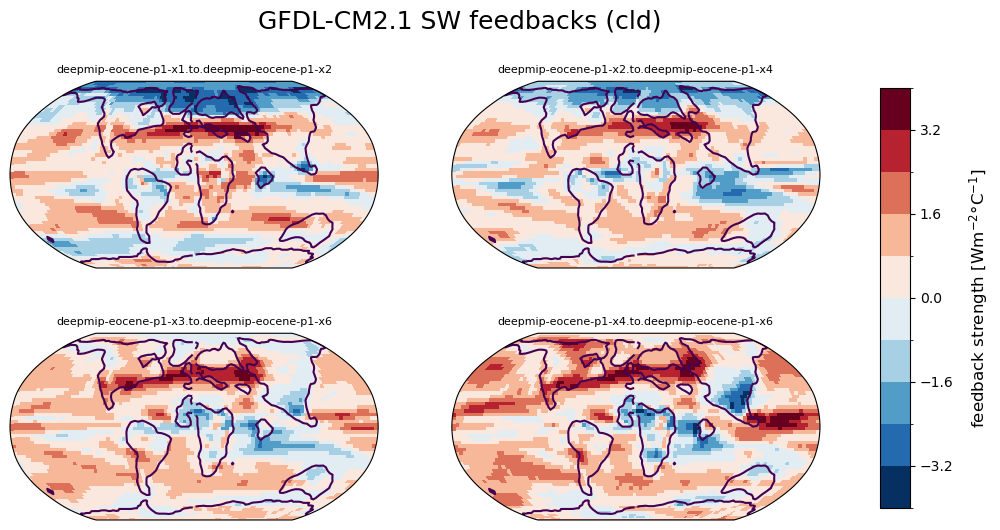

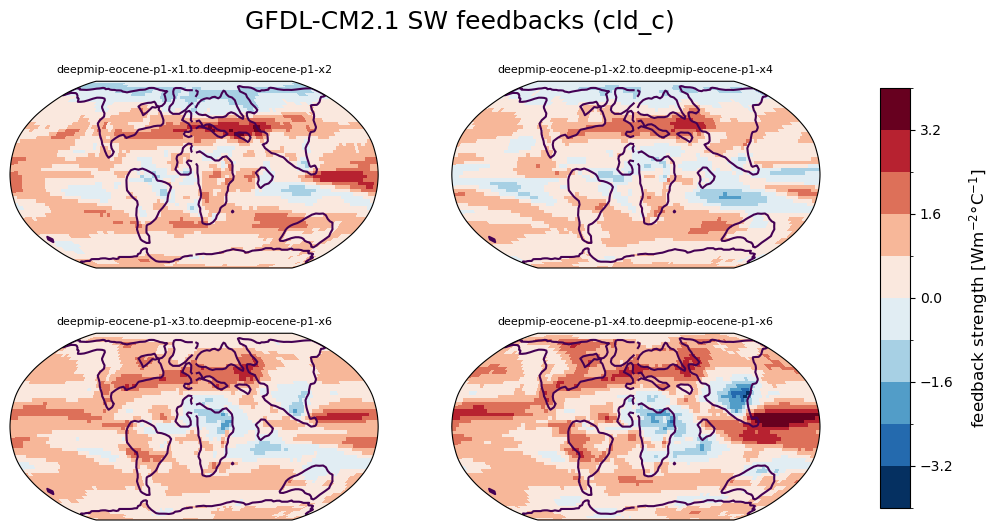

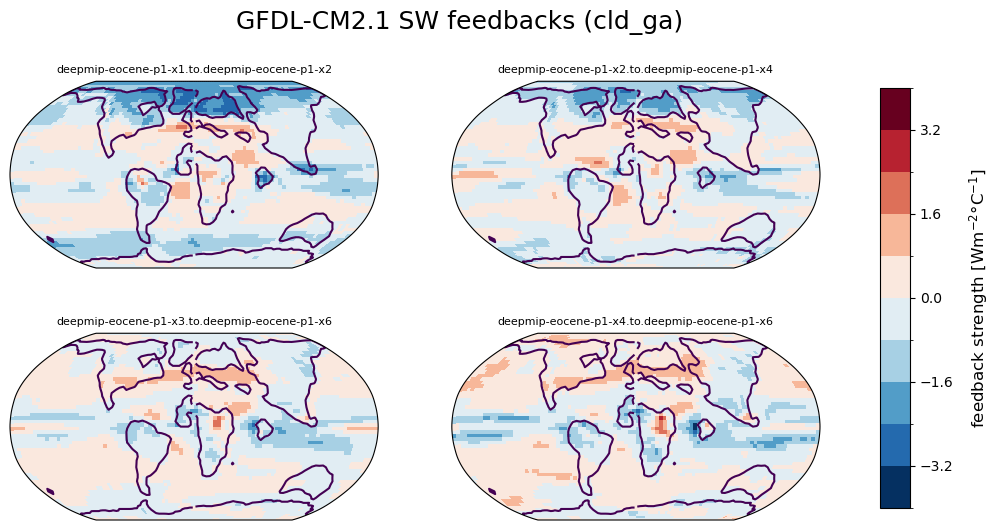

In [8]:
plot_feedback_maps('cld', 'GFDL-CM2.1', -4, 4)
plot_feedback_maps('cld_c', 'GFDL-CM2.1', -4, 4)
plot_feedback_maps('cld_ga', 'GFDL-CM2.1', -4, 4)


Text(0.5, 0.98, 'GFDL annual mean sea ice cover')

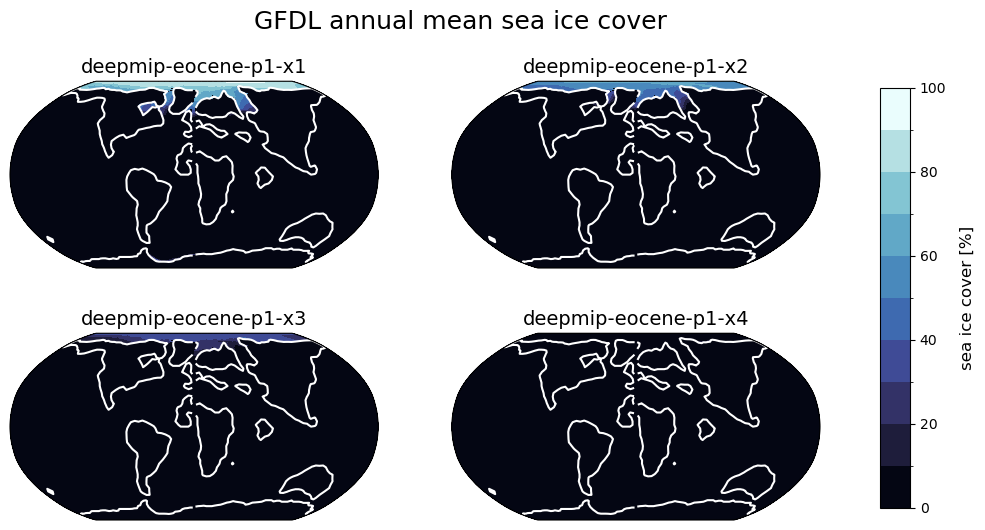

In [9]:
# sea ice maps for GFDL
import cmocean  # Import cmocean

fig, axs = plt.subplots(2, 2, figsize=(12, 6), subplot_kw={'projection': ccrs.Robinson()})

var = 'siconc'
model = 'GFDL-CM2.1'

colormap = cmocean.cm.ice
min_value = 0 
max_value = 100  
number_of_levels = 10 
levels = np.linspace(min_value, max_value, 11)  # 11 edges for 10 intervals
# Create a BoundaryNorm instance
norm = mcolors.BoundaryNorm(levels, ncolors=colormap.N)

row = 0
column = 0
plot_num = 0
for i in range(deepmip_dict[model]['ncase']-1):

    if deepmip_dict[model]['contr'][i] == 'deepmip-eocene-p1-PI':
        continue

    siconc_file = 'siconc_' + model + '_' + deepmip_dict[model]['contr'][i] + '_' + deepmip_dict[model]['versn'] + '.mean.remap.nc'
    siconc      =  xr.open_dataset(deepmip_dir + deepmip_dict[model]['group'] + '/' + model + '/' + deepmip_dict[model]['contr'][i] + '/' + deepmip_dict[model]['versn'] + '/climatology/' + siconc_file, decode_times=False)
    
    # land-sea mask
    lsm_file = 'sftlf_' + model + '_' + deepmip_dict[model]['contr'][i] + '_' + deepmip_dict[model]['versn'] + '.nc'
    lsm      =  xr.open_dataset(deepmip_dir + deepmip_dict[model]['group'] + '/' + model + '/' + deepmip_dict[model]['contr'][i] + '/' + deepmip_dict[model]['versn'] + '/climatology/' + lsm_file, decode_times=False)
    
    ax = axs[row, column]  # Select the subplot
    ax.set_global()  # Set a global view
    ax.set_title(deepmip_dict[model]['contr'][i], fontsize=14)
    cf = ax.pcolormesh(siconc.lon, siconc.lat, siconc['siconc'].mean('time'), transform=ccrs.PlateCarree(), cmap=colormap, norm=norm)
    cn = ax.contour(lsm.lon, lsm.lat, lsm['sftlf'], colors='white', levels=[50], transform=ccrs.PlateCarree())

    plot_num += 1
    if column == 0:
        column = 1
    else:
        row = 1
        column = 0

# Create an additional axes for the colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.025, 0.7])

# Create the colorbar in the new axes
cbar = fig.colorbar(cf, cax=cbar_ax)
cbar.set_label('sea ice cover [%]', fontsize=12, labelpad=10)  # Set the title here
fig.suptitle(f'GFDL annual mean sea ice cover', fontsize=18)
